In [1]:
import math
import matplotlib.pyplot as plt

In [2]:
class ReactorState:
    def __init__(self,temperature_liquid,temperature_block,agitator_rate,number_cells,
                 volume_liquid,density_liquid, heat_capacity_liquid):
        '''
        All relevant physical information defining the state of the reactor at any instance
        '''   
        self.T          = temperature_liquid
        self.Tb         = temperature_block
        self.rpm        = agitator_rate
        self.ncells     = number_cells
        self.V          = volume_liquid
        self.rho        = density_liquid
        self.Cp         = heat_capacity_liquid
        
    def update(self, temperature_liquid,number_cells):
        '''
        Updates state with new temperature and cell count
        '''
        self.T          = temperature_liquid
        self.ncells     = number_cells

In [3]:
class ThermalModels:
    def __init__(self, q_agitation=0.0001, area=100, 
                 heat_transfer_coefficent=1e-2, flow_rate = 1, T_fresh = 37,rho_fresh = 1.0,Cp_fresh = 4.2):
        '''
        heat from agitator, external block, and flow of new fluid modeled in this class.
        dependent on state variables passed to methods.
        '''
        self.q_agitation = q_agitation                           #W/rpm
        self.area        = area                                  #cm^2
        self.heat_transfer_coefficent = heat_transfer_coefficent #W/cm^2/degC
        self.flow_rate   = flow_rate                             #cc/s
        self.T_fresh     = T_fresh                               #degC
        self.rho_fresh   = rho_fresh                             #g/cc
        self.Cp_fresh    = Cp_fresh                              #J/g/degC
        
    def heat_agitation(self,state):
        '''
        returns enthalpy from agitator at the given state.rpm
        '''
        return state.rpm*self.q_agitation
    
    def heat_control(self,state):
        '''
        returns enthalpy from block, depends on block temp (state.Tb) and liquid temp (state.T)
        '''
        return self.area*self.heat_transfer_coefficent*(state.Tb-state.T)
    
    def heat_flow(self,state):
        '''
        returns enthalpy from fresh flow, depends on liquid temp (state.T)
        '''
        return self.flow_rate*self.rho_fresh*self.Cp_fresh*(self.T_fresh-state.T)

In [4]:
class ReactionModels:
    def __init__(self,q_reaction=1e-6,param_A = 3e2, param_Tmax = 38, param_Tmin = 35):
        '''
        reaction models to estimate heat generated/consumed in cell growth
        '''
        self.q_reaction  = q_reaction                 #W/cell present, +ve=>heat generated
        self.param_A     = param_A    #sqrt(cells/s)
        self.param_Tmax  = param_Tmax #degC
        self.param_Tmin  = param_Tmin #degC
        
    def growth_rate(self,state):
        '''
        If liquid T is below Tmin or greater than Tmax no cell growth occurs.
        In reality we should include cell death also. Not included here. 
        If conditions are optimal, cell growth happens.
        See Eq 2/3 from http://www.pfigueiredo.org/MAI13.pdf
        '''
        if state.T < self.param_Tmin or state.T > self.param_Tmax:
            growth_rate = 0
        else:
            growth_rate = math.pow(self.param_A*(1-math.exp(state.T-self.param_Tmax)),2)
        return growth_rate
    
    def heat_reaction(self,state):
        '''
        returns enthalpy of cell growth, depends potentially on number of cells (state.ncells)
        '''
        return state.ncells*self.q_reaction

In [5]:
def discrete_time_simulator(state,thermal,reaction,max_time=100.0,t_step=0.1):
    '''
    Steps the simulation in time
    inputs: state, thermal model, reaction model, max_time (optional), t_step (optional)
    outputs: list of times, list of temperatures, list of rate of change of temperatures, 
             list of cell count, and list of rate of cell change
    '''
    T_list, time_list, dT_dt_list, Cells_list, dCells_dt_list = [],[],[],[],[]
   
    T             = state.T
    number_cells  = state.ncells

    #Physics of heating: energy input from 4 sources considered-
    #agitation, control block, flow of fresh fluid, reaction (i.e. cell growth)
    heat_sources = [thermal.heat_agitation,thermal.heat_control,thermal.heat_flow,
                    reaction.heat_reaction]
    t = 0.0
    while t <= max_time: 
        dT_dt,dCells_dt = 0,0
        for source in heat_sources:
            dT_dt+= source(state) 
        
        #Rates of change
        dT_dt    /= (state.rho*state.Cp*state.V)  
        dCells_dt = reaction.growth_rate(state)
        
        #Time stepping 
        T            += dT_dt     *t_step
        number_cells += dCells_dt *t_step
        
        #Output lists
        time_list.append(t)
        T_list.append(state.T)
        dT_dt_list.append(dT_dt) 
        Cells_list.append(state.ncells/1e6)  #convert to million cell basis
        dCells_dt_list.append(dCells_dt/1e6) #convert to million cell basis

        #Create a new state
        state.update(T,number_cells)
        t+= t_step
    
    return  time_list, T_list, dT_dt_list, Cells_list, dCells_dt_list

In [6]:
#Inputs from problem statement
temperature_liquid      = 37    #degC
temperature_block       = 35    #degC
agitator_rate           = 100   #rpm
number_cells            = 1e6   #- 
volume_liquid           = 50    #mL
density_liquid          = 1     #g/mL, assumed aqueous

#Other inputs assumed
heat_capacity_liquid    = 4.2   #J/g/degC


In [7]:
#Initialize reactor state
state = ReactorState(temperature_liquid,temperature_block,agitator_rate,number_cells,
                     volume_liquid,density_liquid,heat_capacity_liquid)

In [8]:
#Construct models (thermal and reaction)
thermal     = ThermalModels()
reaction    = ReactionModels() 

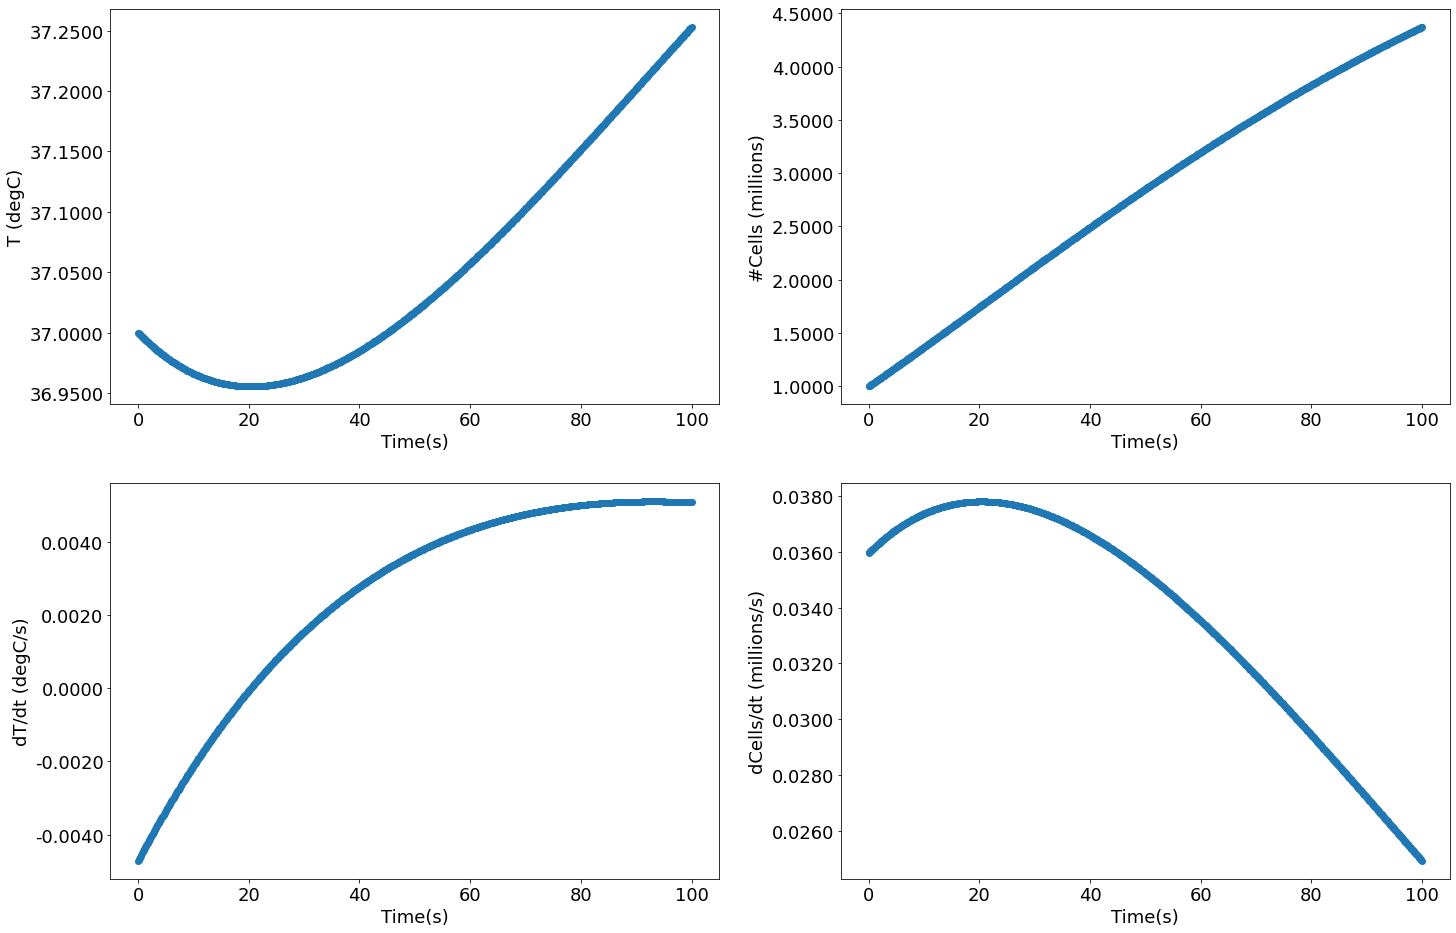

In [9]:
#Run simulation and plot
time_list, T_list, dT_dt_list, Cells_list, dCells_dt_list = discrete_time_simulator(state,thermal,reaction)
x = time_list
y1 = T_list
y2 = dT_dt_list
y3 = Cells_list
y4 = dCells_dt_list

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(2, 2,figsize=(24,16))
axs[0, 0].scatter(x, y1)
axs[0,0].set(xlabel='Time(s)', ylabel='T (degC)')

axs[1,0].scatter(x,y2)
axs[1,0].set(xlabel='Time(s)', ylabel='dT/dt (degC/s)')

axs[0,1].scatter(x,y3)
axs[0,1].set(xlabel='Time(s)', ylabel='#Cells (millions)')

axs[1,1].scatter(x,y4)
axs[1,1].set(xlabel='Time(s)', ylabel='dCells/dt (millions/s)')

for ax in axs.flat:
    ax.yaxis.set_major_formatter('{x:9<4.4f}')

 **Unit Tests**

In [10]:
import unittest

In [11]:
class TestBioreactor(unittest.TestCase):
    
    def get_default_initial_state(self):
        '''
        Default initial reactor state for testing
        '''
        #Inputs from problem statement
        temperature_liquid      = 37    #degC
        temperature_block       = 35    #degC
        agitator_rate           = 100   #rpm
        number_cells            = 1e6   #- 
        volume_liquid           = 100   #mL
        density_liquid          = 1     #g/mL, assumed aqueous

        #Other inputs assumed
        heat_capacity_liquid    = 4.2   #J/g/degC

        #Initialize reactor state
        state = ReactorState(temperature_liquid,temperature_block,agitator_rate,number_cells,
                             volume_liquid,density_liquid,heat_capacity_liquid)
        return state
    
    def test_high_inflow(self):
        '''
        Steady state liquid T = within 1% of fresh stream temperature at high inlet flow
        '''
        state     = self.get_default_initial_state()
        T_fresh   = 100 #degC
        thermal   = ThermalModels(flow_rate = 1000, T_fresh = T_fresh)
        reaction  = ReactionModels() 
        
        expected_steady_state_T = T_fresh
        
        time_list, T_list, dT_dt_list, Cells_list, dCells_dt_list = discrete_time_simulator(state,thermal,reaction,
                                                                                            max_time=100.0)
        
        self.assertTrue(abs(round(T_list[-1],1)-expected_steady_state_T)<0.01*expected_steady_state_T)
        
    def test_high_transfer_from_block(self):
        '''
        Steady state liquid T = within 1% of T_block at high heat transfer coefficient
        '''
        state     = self.get_default_initial_state()
        T_block   = 100 #degC
        state.Tb  = T_block #default state override
        thermal   = ThermalModels(heat_transfer_coefficent=50)
        reaction  = ReactionModels() 
        
        expected_steady_state_T = T_block
        
        time_list, T_list, dT_dt_list, Cells_list, dCells_dt_list = discrete_time_simulator(state,thermal,reaction,
                                                                                            max_time=100.0)
        self.assertTrue(abs(round(T_list[-1],1)-expected_steady_state_T)<0.01*expected_steady_state_T)
        
    def test_no_cell_growth(self):
        '''
        cell_count final = cell_count initial if conditions for growth are never achieved 
        as param_Tmax is too low (i.e. reactor is too warm)
        '''
        state     = self.get_default_initial_state()
        thermal   = ThermalModels()
        reaction  = ReactionModels(param_Tmax = 0) 
        
        expected_steady_state_cells = state.ncells/1e6 #output is in millions
        
        time_list, T_list, dT_dt_list, Cells_list, dCells_dt_list = discrete_time_simulator(state,thermal,reaction)
        self.assertEqual(round(Cells_list[-1],1),expected_steady_state_cells)

unittest.main(argv=[''], verbosity=2, exit=False)

test_high_inflow (__main__.TestBioreactor)
Steady state liquid T = within 1% of fresh stream temperature at high inlet flow ... ok
test_high_transfer_from_block (__main__.TestBioreactor)
Steady state liquid T = within 1% of T_block at high heat transfer coefficient ... ok
test_no_cell_growth (__main__.TestBioreactor)
cell_count final = cell_count initial if conditions for growth are never achieved ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.090s

OK
